In [153]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc, accuracy_score
from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 500)

# PCA

In [121]:
img_df = pd.read_csv("/Users/johngalvin/Downloads/AD1ChallengeImagingFiles/baseline_data.csv")
img_ptids = img_df["Subject"]
X = img_df.iloc[:,:-13] # Keep just image features

/Users/johngalvin/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (2162) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [122]:
# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [123]:
# Cov matrix
cov = (X_scaled.T @ X_scaled) / (X_scaled.shape[0] - 1)

In [124]:
# Eigendecomposition
eig_values, eig_vectors = np.linalg.eig(cov)

In [125]:
# Figure out which components to select
idx = np.argsort(eig_values, axis=0)[::-1]
sorted_eig_vectors = eig_vectors[:, idx]

/Users/johngalvin/miniforge3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


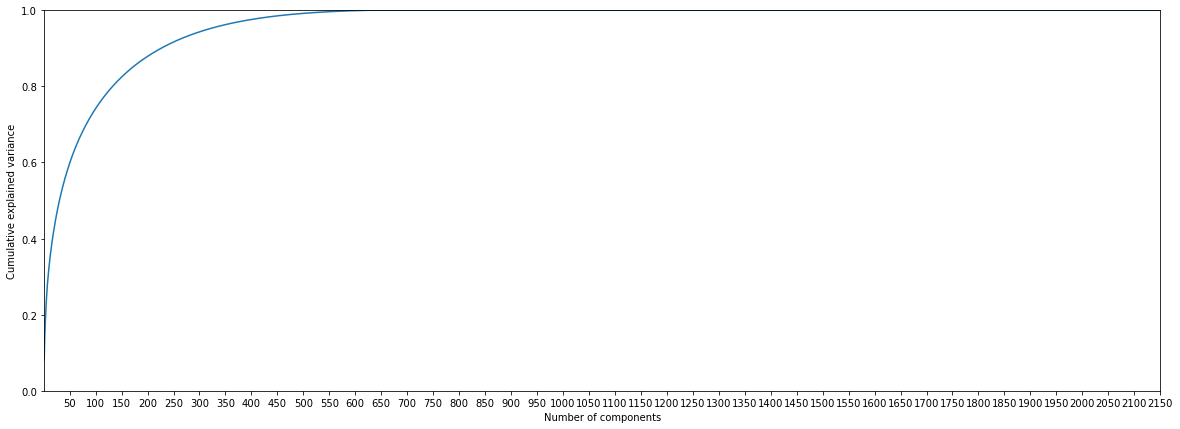

In [126]:
# Determine how many components to keep
cumsum = np.cumsum(eig_values[idx]) / np.sum(eig_values[idx])
xint = range(1, len(cumsum) + 1)
plt.figure(figsize=(20, 7))
plt.plot(xint, cumsum)

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.xticks(np.arange(0, 2151, 50))
plt.xlim(1, len(cumsum))
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1 if necessary

plt.show()

In [127]:
# Determine names of components
num_components_to_keep = 150
selected_eigenvectors = sorted_eig_vectors[:, :num_components_to_keep]

# Get the column names corresponding to the selected eigenvectors
selected_component_names = img_df.columns[:-13][np.argsort(np.abs(selected_eigenvectors.sum(axis=1)))[::-1][:num_components_to_keep]]
selected_component_names = selected_component_names.tolist()

In [128]:
# Reconstruct df
img_df = img_df[selected_component_names]
img_df = pd.concat([img_ptids, img_df], axis=1)
img_df.reset_index(drop=True, inplace=True)
img_df.rename({"Subject": "PTID"}, axis=1, inplace=True)

# Merge MRI and Clinical/Genetic Data

In [129]:
# Read in med/famhist
mf_hist = pd.read_csv('../data/clinical_training_data.csv')

# Handle Nan
mf_hist["APOE4"] = mf_hist["APOE4"].fillna(0)

# Join with img_df
df = pd.merge(mf_hist, img_df, on="PTID", how="inner")

# For converting categorical variables to ints
label_encoder = LabelEncoder()
scaler = MinMaxScaler()

# Split features / target
X = df.drop(columns=['PTID',
                     'AD_dx_in_5_yrs', 
                     'AD_dx_in_any_time', 
                     'AD_dx_in_15_yrs',
                     'AD_dx_in_10_yrs', 
                     'AD_dx_in_4_yrs', 
                     'AD_dx_in_3_yrs',
                     'AD_dx_in_2_yrs', 
                     'AD_dx_in_1_yr'])
y = df['AD_dx_in_5_yrs']

# Encode features
X["Diagnosis_at_Baseline"] = label_encoder.fit_transform(X["Diagnosis_at_Baseline"])
X["Gender"] = label_encoder.fit_transform(X["Gender"])
X["Ethnicity"] = label_encoder.fit_transform(X["Ethnicity"])
X["Race"] = label_encoder.fit_transform(X["Race"])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [130]:
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [134]:
# Reorder labels (order changed when forming unscaled_mri_df)
y_train_final = []
for val in X_train.index.values:
    y_train_final.append(df.loc[df.index == val, "AD_dx_in_5_yrs"].values[0])
y_train_final = np.array(y_train_final)

y_val_final = []
for val in X_val.index.values:
    y_val_final.append(df.loc[df.index == val, "AD_dx_in_5_yrs"].values[0])
y_val_final = np.array(y_val_final)

y_test_final = []
for val in X_test.index.values:
    y_test_final.append(df.loc[df.index == val, "AD_dx_in_5_yrs"].values[0])
y_test_final = np.array(y_test_final)

In [135]:
# Oversample
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_scaled, y_train_final)

# Train

In [136]:
IN_FEATURES = X_train_scaled[0].shape[0]

In [160]:
def create_model(dropout=0.3, learning_rate=0.001, l1_penalty=0.001, l2_penalty=0.001):
    """Builds classification model"""
    
    model = tf.keras.Sequential()
    inputs = tf.keras.layers.Input(shape=(IN_FEATURES,), name="input_layer") # (Batch, num_features)
    
    hidden_1 = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1_penalty, l2=l2_penalty), name="hidden_1")(inputs)
    hidden_1 = tf.keras.layers.Dropout(dropout)(hidden_1)
    hidden_2 = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1_penalty, l2=l2_penalty), name="hidden_2")(hidden_1)
    hidden_2 = tf.keras.layers.Dropout(dropout)(hidden_2)
    
    classification = tf.keras.layers.Dense(1, activation="sigmoid", name="classification_layer")(hidden_1)
    classification_model = tf.keras.Model(inputs=[inputs], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                                 metrics="accuracy")

    return classification_model

In [161]:
model = create_model()

In [162]:
es = EarlyStopping(monitor="val_loss", 
                   patience=4,
                   verbose=0,
                   restore_best_weights=True)

tf.config.run_functions_eagerly(True)
history = model.fit(X_train_resampled,
                    y_train_resampled,
                    validation_data=[X_val_scaled, y_val_final],
                    batch_size=16,
                    epochs=20)

Epoch 1/20
27/27 [==============================] - 1s 24ms/step - loss: 3.1903 - accuracy: 0.6174 - val_loss: 3.0078 - val_accuracy: 0.6125
Epoch 2/20
27/27 [==============================] - 1s 24ms/step - loss: 2.6479 - accuracy: 0.8568 - val_loss: 2.7520 - val_accuracy: 0.7125
Epoch 3/20
27/27 [==============================] - 1s 23ms/step - loss: 2.3017 - accuracy: 0.9366 - val_loss: 2.5202 - val_accuracy: 0.7250
Epoch 4/20
27/27 [==============================] - 1s 23ms/step - loss: 2.0219 - accuracy: 0.9577 - val_loss: 2.2926 - val_accuracy: 0.7250
Epoch 5/20
27/27 [==============================] - 1s 23ms/step - loss: 1.7822 - accuracy: 0.9765 - val_loss: 2.1189 - val_accuracy: 0.7125
Epoch 6/20
27/27 [==============================] - 1s 24ms/step - loss: 1.5677 - accuracy: 0.9859 - val_loss: 1.9271 - val_accuracy: 0.7125
Epoch 7/20
27/27 [==============================] - 1s 23ms/step - loss: 1.3984 - accuracy: 0.9812 - val_loss: 1.7887 - val_accuracy: 0.7250
Epoch 8/20
27

In [163]:
print ("If simply guessing all 0, can get this train accuracy:", 1 - y_train_resampled.sum() / y_train_resampled.shape[0])
print ("If simply guessing all 0, can get this val accuracy:", 1 - y_val_final.sum() / y_val_final.shape[0])
print ("If simply guessing all 0, can get this test accuracy:", 1 - y_test_final.sum() / y_test_final.shape[0])

If simply guessing all 0, can get this train accuracy: 0.5
If simply guessing all 0, can get this val accuracy: 0.6125
If simply guessing all 0, can get this test accuracy: 0.6599999999999999


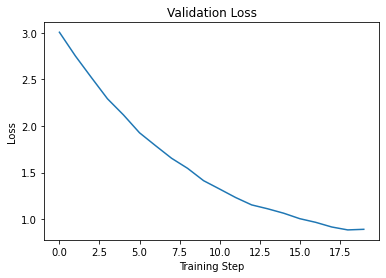

In [164]:
# Visualize loss curve

losses = history.history["val_loss"]
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.show()

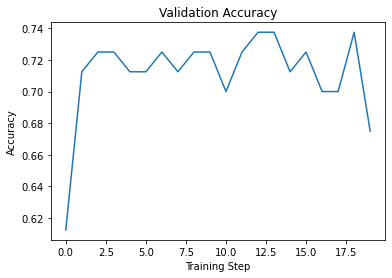

In [165]:
# Visualize accuracy curve

losses = history.history["val_accuracy"]
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.show()

# K-fold Cross-Validation

In [172]:
# Initialize kf
num_folds = 5
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Train
acc_per_fold = []
loss_per_fold = []

fold_no = 1
for train, val in kf.split(X_train_resampled, y_train_resampled):
    model = create_model()
    
    history = model.fit(X_train_resampled[train], 
                        y_train_resampled[train], 
                        epochs=15, 
                        batch_size=32, 
                        validation_data=(X_train_resampled[val], y_train_resampled[val]))
    
    # Generate generalization metrics
    scores = model.evaluate(X_test_scaled, y_test_final, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    fold_no += 1

# Print average metrics
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Epoch 1/15
 4/11 [=========>....................] - ETA: 0s - loss: 3.4197 - accuracy: 0.4922

/Users/johngalvin/miniforge3/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/johngalvin/miniforge3/lib/python3.9/site-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


11/11 [==============================] - 0s 34ms/step - loss: 3.3437 - accuracy: 0.5176 - val_loss: 3.1045 - val_accuracy: 0.6395
Epoch 2/15
11/11 [==============================] - 0s 24ms/step - loss: 2.9583 - accuracy: 0.7676 - val_loss: 2.8980 - val_accuracy: 0.7558
Epoch 3/15
11/11 [==============================] - 0s 26ms/step - loss: 2.7107 - accuracy: 0.8529 - val_loss: 2.7235 - val_accuracy: 0.7791
Epoch 4/15
11/11 [==============================] - 0s 25ms/step - loss: 2.5126 - accuracy: 0.9088 - val_loss: 2.5550 - val_accuracy: 0.8605
Epoch 5/15
11/11 [==============================] - 0s 24ms/step - loss: 2.3234 - accuracy: 0.9353 - val_loss: 2.3931 - val_accuracy: 0.8721
Epoch 6/15
11/11 [==============================] - 0s 25ms/step - loss: 2.1717 - accuracy: 0.9382 - val_loss: 2.2490 - val_accuracy: 0.8721
Epoch 7/15
11/11 [==============================] - 0s 25ms/step - loss: 2.0290 - accuracy: 0.9559 - val_loss: 2.1075 - val_accuracy: 0.8837
Epoch 8/15
11/11 [======

11/11 [==============================] - 0s 24ms/step - loss: 1.3616 - accuracy: 0.9912 - val_loss: 1.5726 - val_accuracy: 0.8471
Epoch 13/15
11/11 [==============================] - 0s 24ms/step - loss: 1.2668 - accuracy: 0.9971 - val_loss: 1.4914 - val_accuracy: 0.8471
Epoch 14/15
11/11 [==============================] - 0s 24ms/step - loss: 1.1748 - accuracy: 1.0000 - val_loss: 1.4142 - val_accuracy: 0.8471
Epoch 15/15
11/11 [==============================] - 0s 24ms/step - loss: 1.1013 - accuracy: 0.9971 - val_loss: 1.3410 - val_accuracy: 0.8471
Score for fold 4: loss of 1.4701075553894043; accuracy of 75.0%
Epoch 1/15
11/11 [==============================] - 0s 27ms/step - loss: 3.2748 - accuracy: 0.5718 - val_loss: 3.1056 - val_accuracy: 0.7059
Epoch 2/15
11/11 [==============================] - 0s 28ms/step - loss: 2.9441 - accuracy: 0.7419 - val_loss: 2.9082 - val_accuracy: 0.7765
Epoch 3/15
11/11 [==============================] - 0s 24ms/step - loss: 2.6929 - accuracy: 0.8416